In [1]:
import re
import ast
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import ks_2samp
from itertools import combinations
from scipy.stats import chi2_contingency
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm
from fuzzywuzzy import fuzz
from gensim import corpora
from gensim.models import LdaModel
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from collections import Counter, defaultdict
import colorsys
import random
from nltk.corpus import wordnet as wn


In [3]:
file_path = 'dataset/'

In [4]:
autism_tweets_df = pd.read_csv(file_path +'austim_tweets_with_sentiment.csv')
control_tweets_df = pd.read_csv(file_path + 'control_tweets_with_sentiment.csv')

<ipython-input-4-12e58cc88827>:1: DtypeWarning: Columns (3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  autism_tweets_df = pd.read_csv(file_path +'austim_tweets_with_sentiment.csv')


# top 20 hashtags

In [5]:
# Function to safely evaluate strings to lists
def safe_eval(val):
    try:
        if isinstance(val, str):
            return ast.literal_eval(val)
        elif isinstance(val, list):
            return val
        else:
            return []
    except:
        return []


# Convert the 'Hashtags' column strings to lists
control_tweets_df['Hashtags'] = control_tweets_df['Hashtags'].apply(safe_eval)
autism_tweets_df['Hashtags'] = autism_tweets_df['Hashtags'].apply(safe_eval)

# Flatten the lists of hashtags and count the frequencies for each dataset
control_hashtags = [
    hashtag for sublist in control_tweets_df['Hashtags'] for hashtag in sublist]
autism_hashtags = [hashtag for sublist in autism_tweets_df['Hashtags']
                   for hashtag in sublist]

control_hashtag_freq = Counter(control_hashtags)
autism_hashtag_freq = Counter(autism_hashtags)

# Convert Counter objects to DataFrames
control_hashtag_df = pd.DataFrame(control_hashtag_freq.items(), columns=[
                                  'Hashtag', 'Count']).sort_values(by='Count', ascending=False)
autism_hashtag_df = pd.DataFrame(autism_hashtag_freq.items(), columns=[
                                 'Hashtag', 'Count']).sort_values(by='Count', ascending=False)

In [6]:
# Print the DataFrames
print("Control Hashtag Frequencies:")
print(control_hashtag_df)

print("\nAutism Hashtag Frequencies:")
print(autism_hashtag_df)

Control Hashtag Frequencies:
                  Hashtag  Count
2064       NintendoSwitch    327
817          iHeartAwards    299
245          WrestleMania    260
2078           SoundCloud    198
557          MarchMadness    190
...                   ...    ...
19995              STEMed      1
19996           maxpucker      1
19997  ALDUB186thWeeksary      1
19998  ALDUB184thWeeksary      1
47841              deeper      1

[47842 rows x 2 columns]

Autism Hashtag Frequencies:
                 Hashtag  Count
8       ActuallyAutistic  55111
14                autism  20656
39                Autism  11000
74              autistic  10209
2       actuallyautistic   9268
...                  ...    ...
63404       AmPublishing      1
12759   AcceptanceIsLove      1
63402       AWritersLife      1
63399        7WordPoetry      1
127023              DeFi      1

[127024 rows x 2 columns]


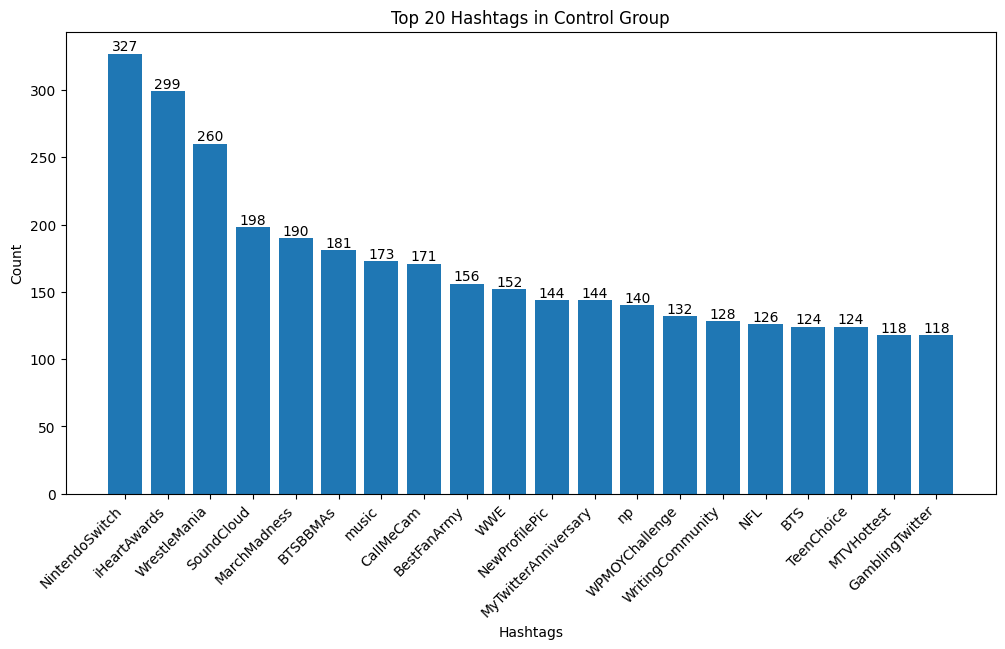

In [7]:
# Plot the top 20 hashtags for the dataset
top_20_control = control_hashtag_df.head(20)

# Control group plot
plt.figure(figsize=(12, 6))
bars = plt.bar(top_20_control['Hashtag'], top_20_control['Count'])
plt.xticks(rotation=45, ha='right')  # Rotate x labels slightly and align right
plt.title('Top 20 Hashtags in Control Group')
plt.xlabel('Hashtags')
plt.ylabel('Count')

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom')

plt.show()

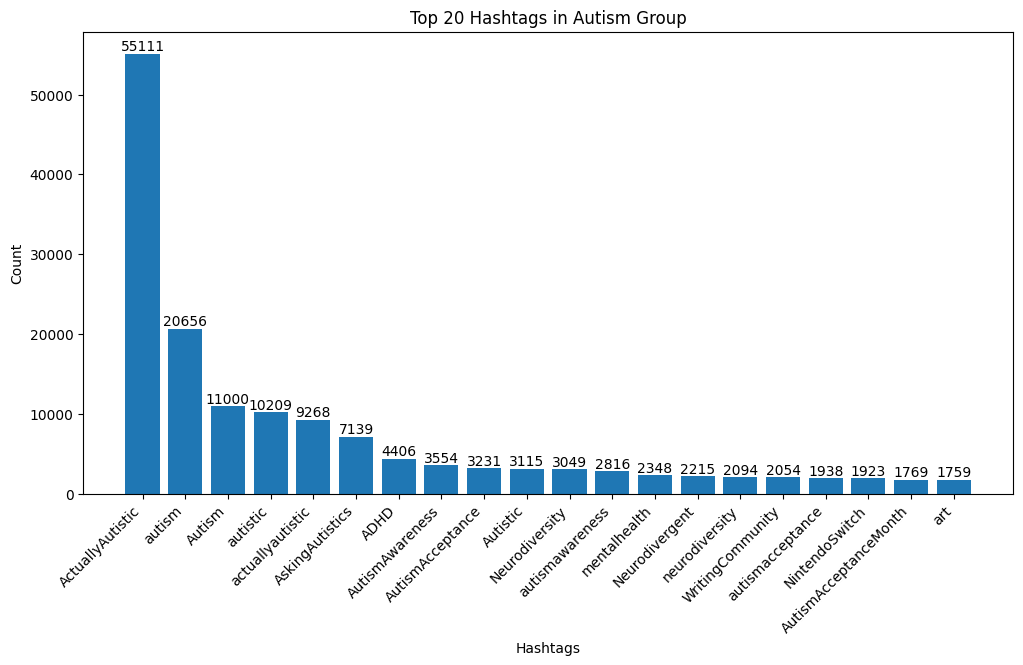

In [8]:
top_20_autism = autism_hashtag_df.head(20)
# Autism group plot
plt.figure(figsize=(12, 6))
bars = plt.bar(top_20_autism['Hashtag'], top_20_autism['Count'])
plt.xticks(rotation=45, ha='right')  # Rotate x labels slightly and align right
plt.title('Top 20 Hashtags in Autism Group')
plt.xlabel('Hashtags')
plt.ylabel('Count')

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom')

plt.show()

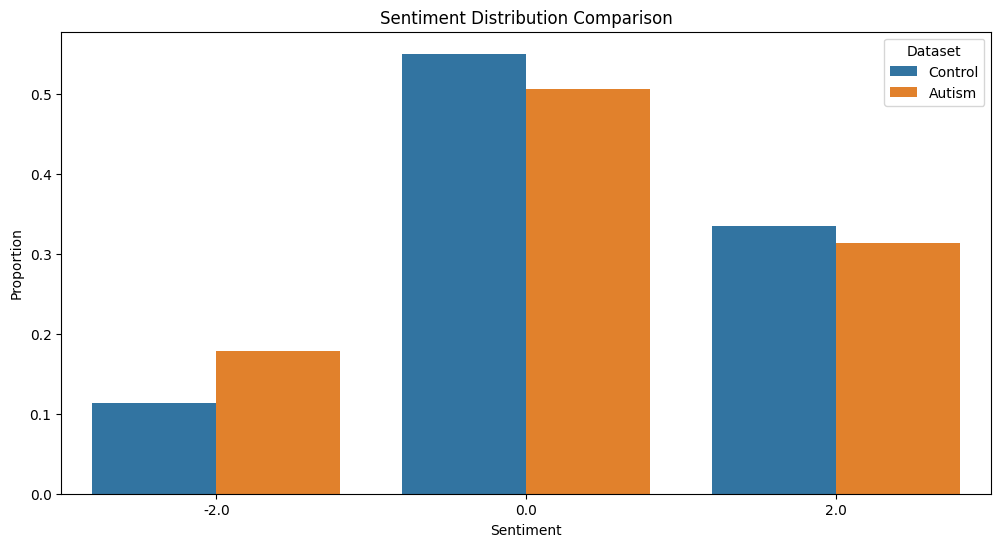

Chi-Square Test Results:
Chi2 Statistic: 3.7218327913723703
P-value: 0.4449584356974774
There is no significant difference in the sentiment distributions between the two groups.


In [9]:
top_20_autism = autism_hashtag_df.head(20)
# Extract sentiment distributions
control_sentiment_dist = control_tweets_df['Tweet Text Sentiment'].value_counts(
    normalize=True)
autism_sentiment_dist = autism_tweets_df['Tweet Text Sentiment'].value_counts(
    normalize=True)

# Combine sentiment distributions into a DataFrame for visualization
sentiment_dist_df = pd.DataFrame({
    'Sentiment': control_sentiment_dist.index,
    'Control': control_sentiment_dist.values,
    'Autism': autism_sentiment_dist.reindex(control_sentiment_dist.index).fillna(0).values
}).melt(id_vars='Sentiment', var_name='Dataset', value_name='Proportion')

# Visualize sentiment distributions
plt.figure(figsize=(12, 6))
sns.barplot(x='Sentiment', y='Proportion',
            hue='Dataset', data=sentiment_dist_df)
plt.title('Sentiment Distribution Comparison')
plt.xlabel('Sentiment')
plt.ylabel('Proportion')
plt.show()

# Statistical test: Chi-Square test of independence
contingency_table = pd.crosstab(
    control_tweets_df['Tweet Text Sentiment'], autism_tweets_df['Tweet Text Sentiment'])
chi2, p, dof, ex = chi2_contingency(contingency_table)

print(f"Chi-Square Test Results:\nChi2 Statistic: {chi2}\nP-value: {p}")

# Interpretation based on p-value
if p < 0.05:
    print("The sentiment distributions between the two groups are significantly different.")
else:
    print("There is no significant difference in the sentiment distributions between the two groups.")

# Sentiment Analysis over Four-Month Periods

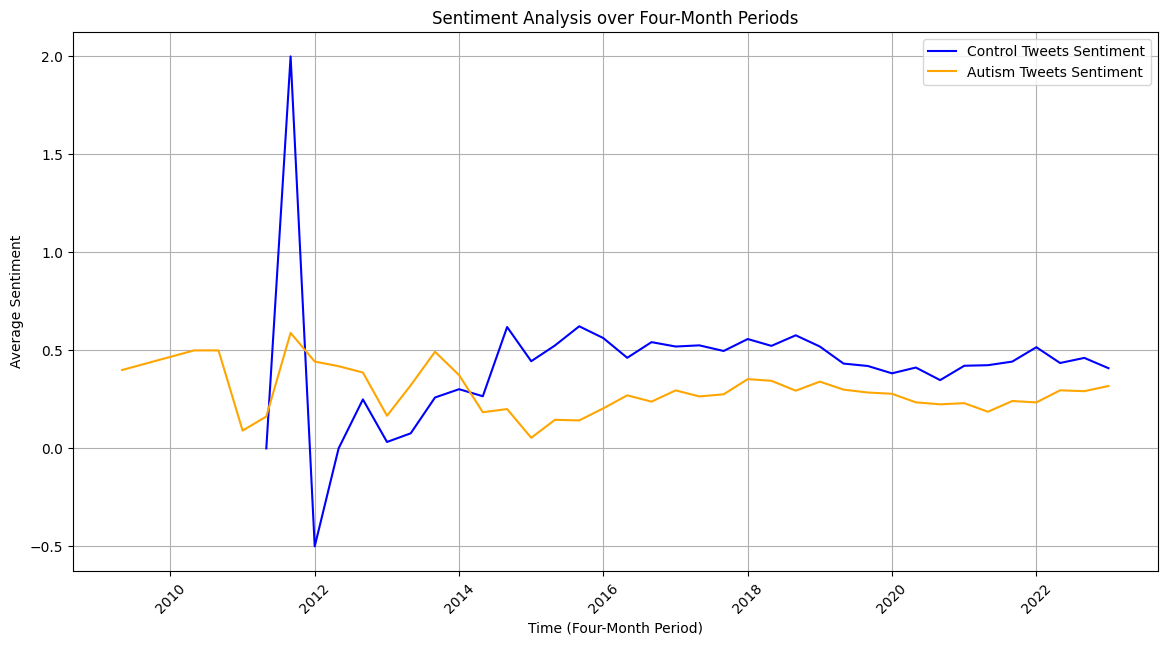

In [10]:
# Convert Tweet date to datetime
control_tweets_df['Tweet date'] = pd.to_datetime(control_tweets_df['Tweet date'], errors='coerce')
autism_tweets_df['Tweet date'] = pd.to_datetime(autism_tweets_df['Tweet date'], errors='coerce')

# Define a function to map dates to four-month periods
def map_to_four_month_period(date):
    if pd.isnull(date):
        return None
    month = ((date.month - 1) // 4) * 4 + 1
    return pd.Timestamp(year=date.year, month=month, day=1)

# Create a new column for the custom four-month period
control_tweets_df['FourMonthPeriod'] = control_tweets_df['Tweet date'].apply(map_to_four_month_period)
autism_tweets_df['FourMonthPeriod'] = autism_tweets_df['Tweet date'].apply(map_to_four_month_period)

# Calculate average sentiment per four-month period
control_sentiment_over_time = control_tweets_df.groupby('FourMonthPeriod')['Tweet Text Sentiment'].mean().reset_index()
autism_sentiment_over_time = autism_tweets_df.groupby('FourMonthPeriod')['Tweet Text Sentiment'].mean().reset_index()

# Plotting sentiment over time
plt.figure(figsize=(14, 7))
plt.plot(control_sentiment_over_time['FourMonthPeriod'], control_sentiment_over_time['Tweet Text Sentiment'], label='Control Tweets Sentiment', color='blue')
plt.plot(autism_sentiment_over_time['FourMonthPeriod'], autism_sentiment_over_time['Tweet Text Sentiment'], label='Autism Tweets Sentiment', color='orange')
plt.xlabel('Time (Four-Month Period)')
plt.ylabel('Average Sentiment')
plt.title('Sentiment Analysis over Four-Month Periods')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Calculate the average Tweet Text Sentiment per user

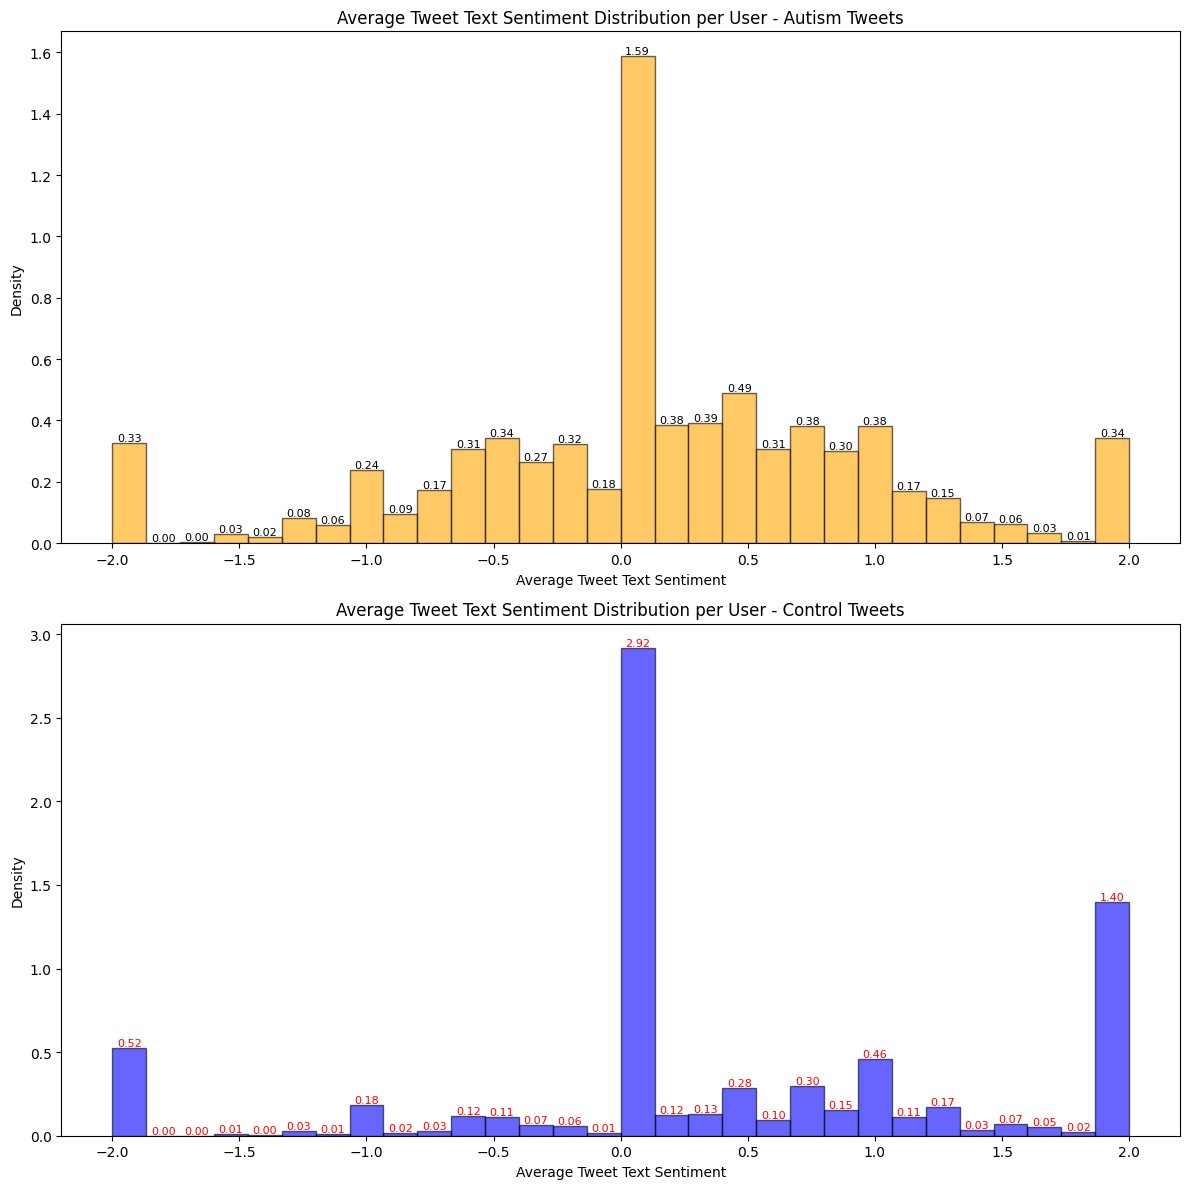

In [11]:
# Calculate the average Tweet Text Sentiment per user for autism tweets
user_sentiment_autism = autism_tweets_df.groupby('User_ID')['Tweet Text Sentiment'].mean().reset_index()
user_sentiment_autism.fillna(0, inplace=True)

# Calculate the average Tweet Text Sentiment per user for control tweets
user_sentiment_control = control_tweets_df.groupby('User_ID')['Tweet Text Sentiment'].mean().reset_index()
user_sentiment_control.fillna(0, inplace=True)

# Set up the subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# Plot for Autism Tweets
axes[0].hist(user_sentiment_autism['Tweet Text Sentiment'], bins=30, density=True, alpha=0.6, color='orange', edgecolor='black')
axes[0].set_title('Average Tweet Text Sentiment Distribution per User - Autism Tweets')
axes[0].set_xlabel('Average Tweet Text Sentiment')
axes[0].set_ylabel('Density')

# Plot for Control Tweets
axes[1].hist(user_sentiment_control['Tweet Text Sentiment'], bins=30, density=True, alpha=0.6, color='blue', edgecolor='black')
axes[1].set_title('Average Tweet Text Sentiment Distribution per User - Control Tweets')
axes[1].set_xlabel('Average Tweet Text Sentiment')
axes[1].set_ylabel('Density')

# Add text annotations
bins = 30
n_autism, bins_autism, _ = axes[0].hist(user_sentiment_autism['Tweet Text Sentiment'], bins=bins, density=True, alpha=0)
bin_centers_autism = 0.5 * (bins_autism[:-1] + bins_autism[1:])
for count, x in zip(n_autism, bin_centers_autism):
    axes[0].text(x, count, f'{count:.2f}', ha='center', va='bottom', fontsize=8, color='black')

n_control, bins_control, _ = axes[1].hist(user_sentiment_control['Tweet Text Sentiment'], bins=bins, density=True, alpha=0)
bin_centers_control = 0.5 * (bins_control[:-1] + bins_control[1:])
for count, x in zip(n_control, bin_centers_control):
    axes[1].text(x, count, f'{count:.2f}', ha='center', va='bottom', fontsize=8, color='red')

plt.tight_layout()
plt.show()


# Correlation among metrics and sentiment

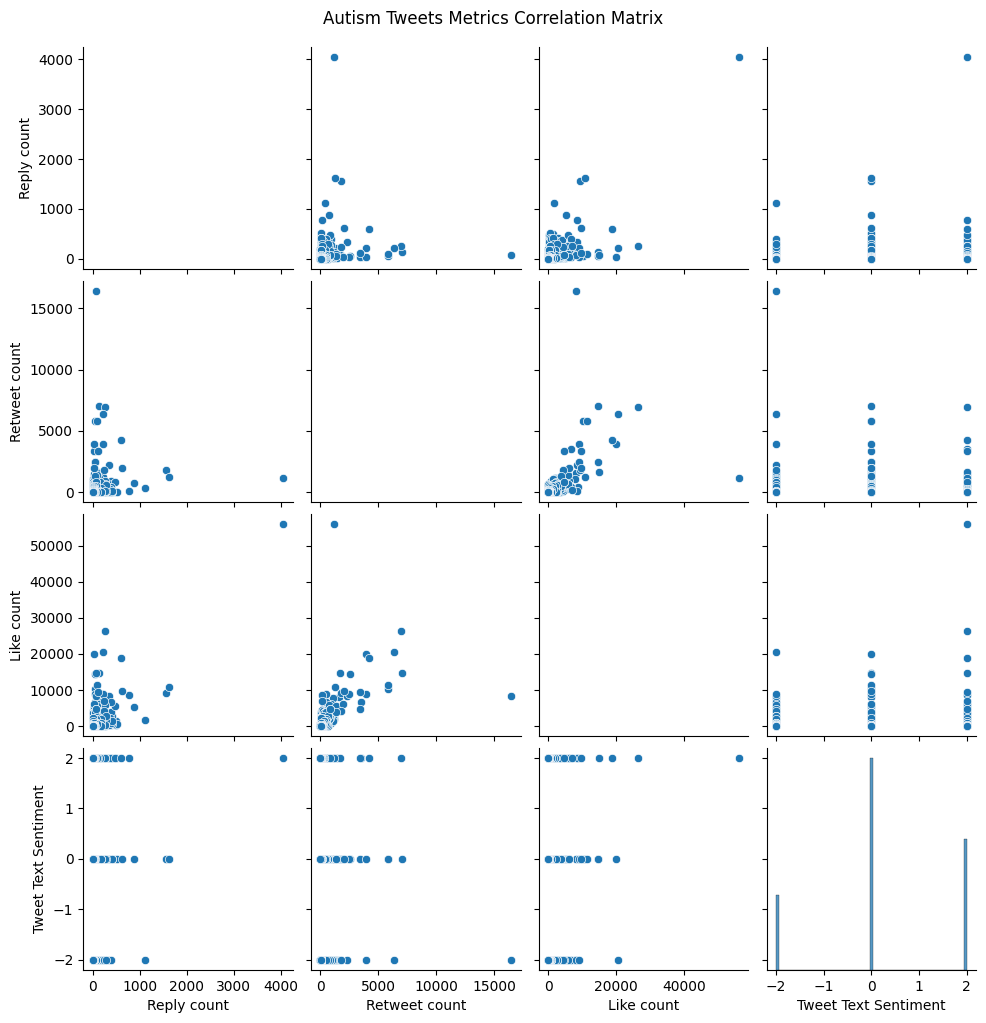

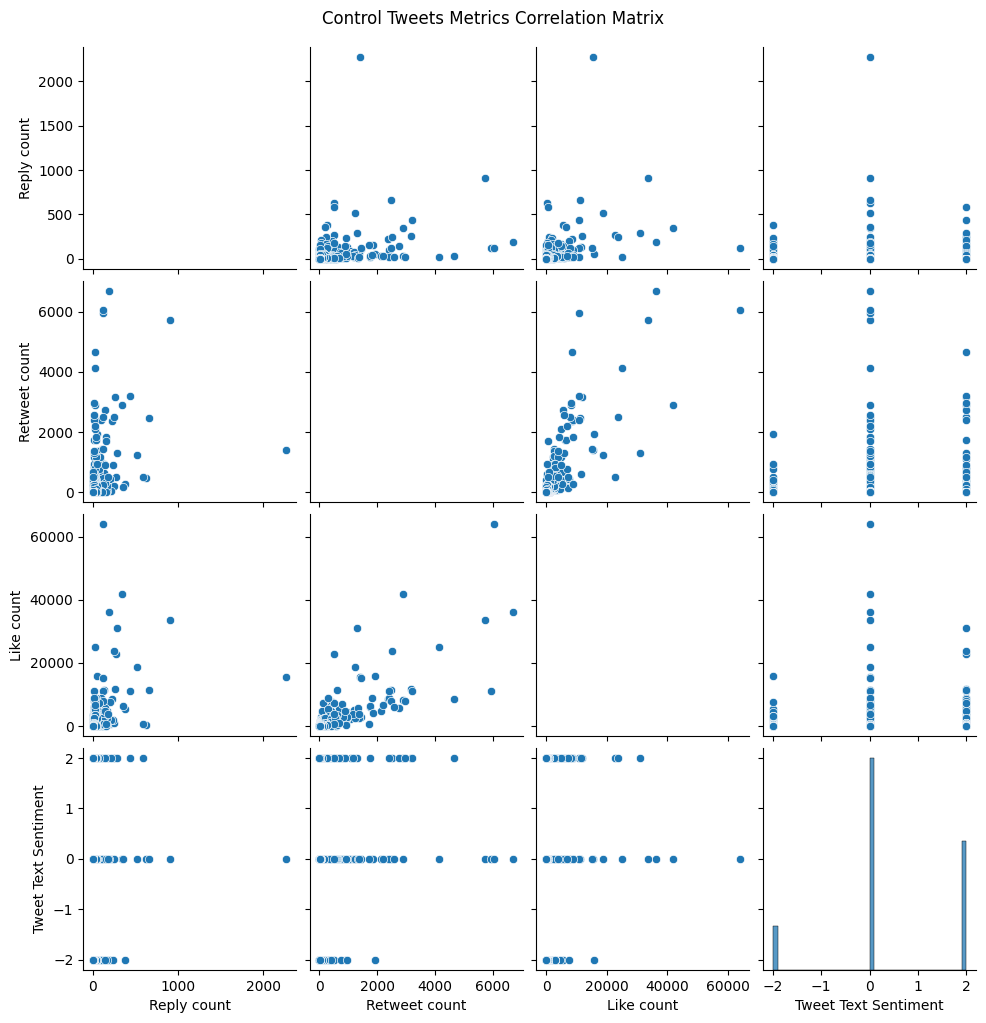

In [12]:
columns_of_interest = ['Reply count', 'Retweet count', 'Like count', 'Tweet Text Sentiment']

# Autism Tweets 数据集的相关矩阵图
sns.pairplot(autism_tweets_df[columns_of_interest])
plt.suptitle('Autism Tweets Metrics Correlation Matrix', y=1.02)
plt.show()

# Control Tweets 数据集的相关矩阵图
sns.pairplot(control_tweets_df[columns_of_interest])
plt.suptitle('Control Tweets Metrics Correlation Matrix', y=1.02)
plt.show()

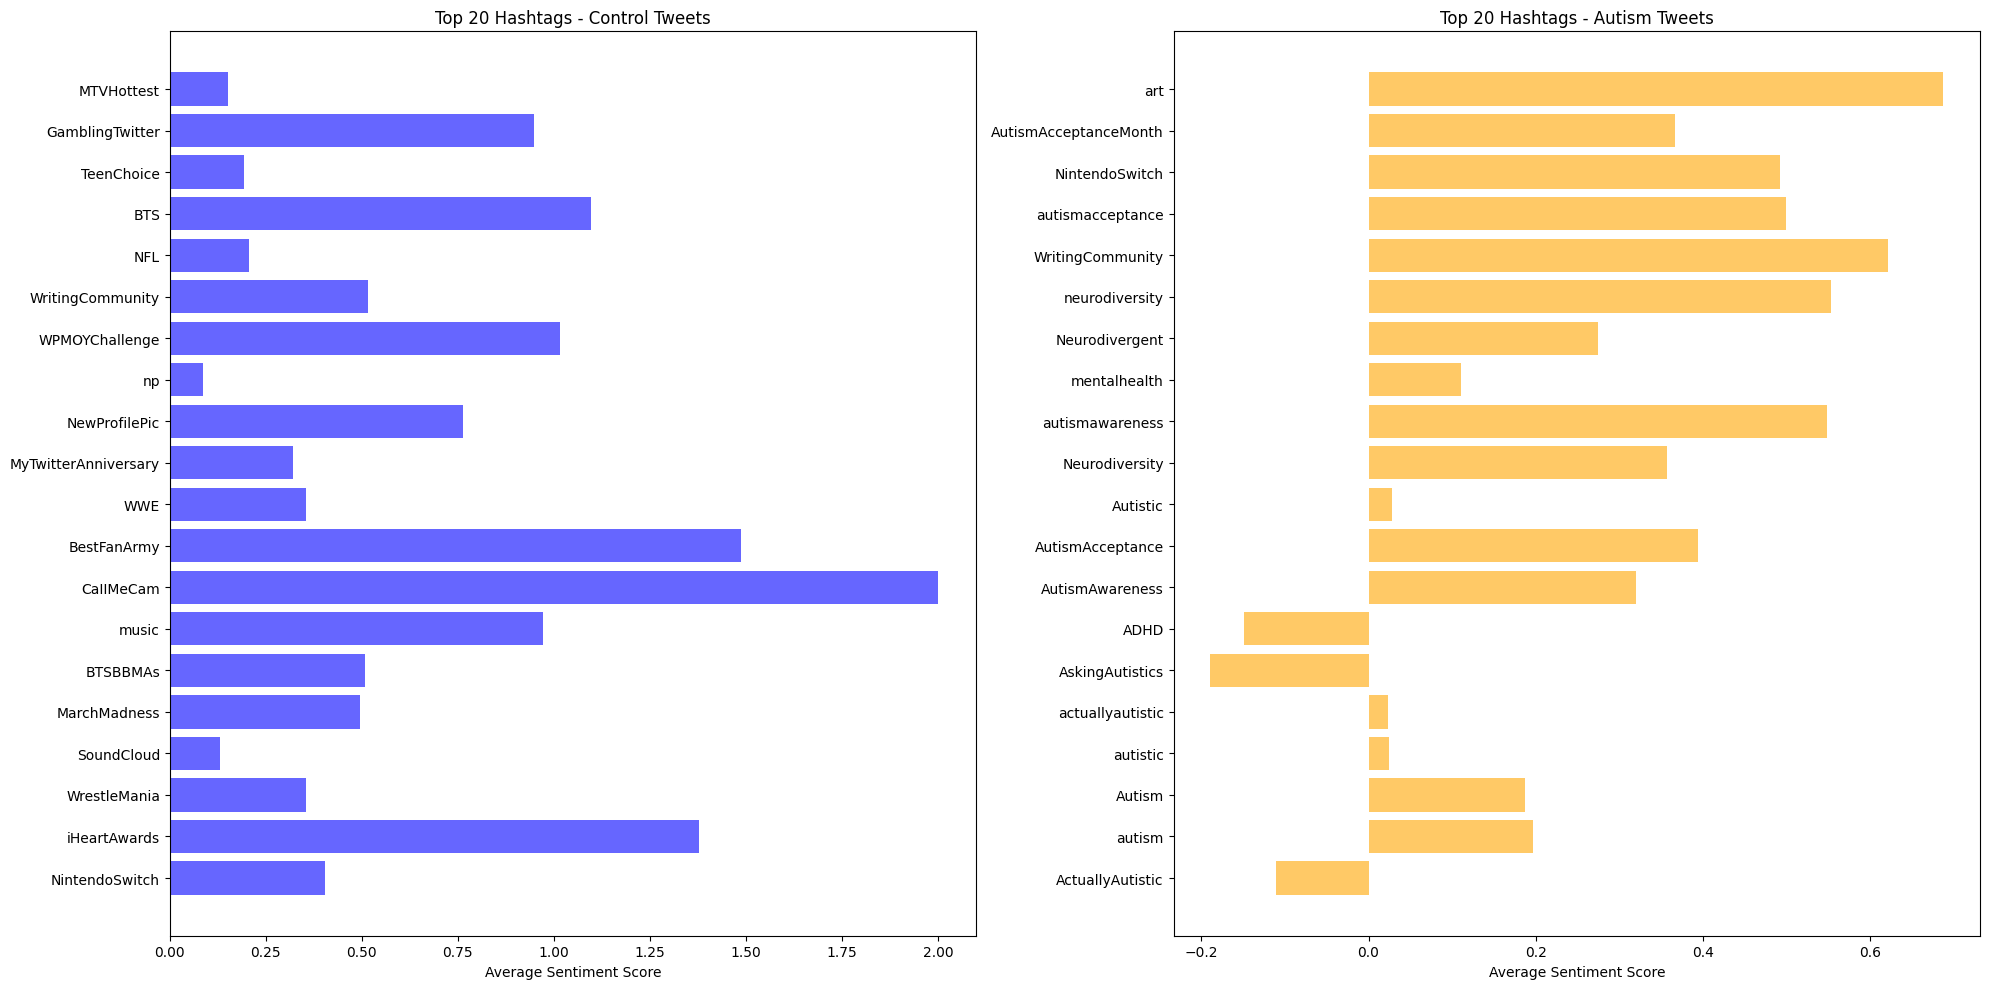

In [13]:
# Flatten the hashtags and calculate average sentiment for each
control_hashtags_sentiment = control_tweets_df.explode('Hashtags').groupby('Hashtags')['Tweet Text Sentiment'].mean().reset_index()
autism_hashtags_sentiment = autism_tweets_df.explode('Hashtags').groupby('Hashtags')['Tweet Text Sentiment'].mean().reset_index()

# Count the occurrences of each hashtag
control_hashtags_count = control_tweets_df.explode('Hashtags')['Hashtags'].value_counts().reset_index()
control_hashtags_count.columns = ['Hashtags', 'Count']
autism_hashtags_count = autism_tweets_df.explode('Hashtags')['Hashtags'].value_counts().reset_index()
autism_hashtags_count.columns = ['Hashtags', 'Count']

# Merge sentiment scores with hashtag counts
control_hashtags_sentiment = control_hashtags_sentiment.merge(control_hashtags_count, on='Hashtags')
autism_hashtags_sentiment = autism_hashtags_sentiment.merge(autism_hashtags_count, on='Hashtags')

# Get top 20 and top 50 hashtags
top20_control_hashtags = control_hashtags_sentiment.sort_values(by='Count', ascending=False).head(20)

top20_autism_hashtags = autism_hashtags_sentiment.sort_values(by='Count', ascending=False).head(20)


# Plot top 20 hashtags
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].barh(top20_control_hashtags['Hashtags'], top20_control_hashtags['Tweet Text Sentiment'], color='blue', alpha=0.6, label='Control')
axes[0].set_title('Top 20 Hashtags - Control Tweets')
axes[0].set_xlabel('Average Sentiment Score')
axes[1].barh(top20_autism_hashtags['Hashtags'], top20_autism_hashtags['Tweet Text Sentiment'], color='orange', alpha=0.6, label='Autism')
axes[1].set_title('Top 20 Hashtags - Autism Tweets')
axes[1].set_xlabel('Average Sentiment Score')
plt.tight_layout()
plt.show()


# Create tables for top 20 hashtags
top20_control_hashtags_table = top20_control_hashtags[['Hashtags', 'Tweet Text Sentiment']]
top20_autism_hashtags_table = top20_autism_hashtags[['Hashtags', 'Tweet Text Sentiment']]
top20_combined_table = pd.merge(top20_control_hashtags_table, top20_autism_hashtags_table, on='Hashtags', suffixes=('_Control', '_Autism'))

